In [1]:
# Imports
import string
from collections import Counter
from statistics import mean

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import spacy
import textstat
import torch
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from transformers import RobertaTokenizer, RobertaForMaskedLM

# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')


# Constants
nlp = spacy.load('en_core_web_sm')
FUNCTION_WORDS = {'a', 'in', 'of', 'the'}


def remove_prefix(data):
    """
    This function removes a predefined prefix from each text in a given dataset.

    Args:
    data (list of tuples): The data from the dataset. Each element of the list is a tuple, where the first element
    is the text and the second element is its label.

    Returns:
    texts (list): The list of texts after the prefix has been removed.
    labels (list): The list of labels corresponding to the texts.
    """

    texts, labels = zip(*data)

    prefixes = ["Answer:", "Story:", "Article:"]

    for prefix in prefixes:
        texts = [text.split(prefix, 1)[1].strip() if prefix in text else text for text in texts]

    return list(texts), list(labels)


def count_pos_tags_and_special_elements(text):
    """
      This function counts the frequency of POS (Part of Speech) tags, punctuation marks, and function words in a given text.
      It uses the SpaCy library for POS tagging.

      Args:
      text (str): The text for which to count POS tags and special elements.

      Returns:
      pos_counts (dict): A dictionary where keys are POS tags and values are their corresponding count.
      punctuation_counts (dict): A dictionary where keys are punctuation marks and values are their corresponding count.
      function_word_counts (dict): A dictionary where keys are function words and values are their corresponding count.

    """
    # Use SpaCy to parse the text
    doc = nlp(text)

    # Create a counter of POS tags
    pos_counts = Counter(token.pos_ for token in doc)

    # Create a counter of punctuation marks
    punctuation_counts = Counter(token.text for token in doc if token.pos_ == 'PUNCT')

    # Create a counter of function words
    function_word_counts = Counter(token.text for token in doc if token.lower_ in FUNCTION_WORDS)

    return dict(pos_counts), dict(punctuation_counts), dict(function_word_counts)


def load_and_count(dataset_name, data):
    """
       This function loads the texts from the dataset and calculates the frequency of POS tags, punctuation marks,
       and function words.

       Args:
       dataset_name (str): The name of the dataset.
       data (list of tuples): The data from the dataset. Each element of the list is a tuple, where the first element
       is the text and the second element is its label.

       Returns:
       overall_pos_counts (Counter): A Counter object of POS tag frequencies.
       overall_punctuation_counts (Counter): A Counter object of punctuation mark frequencies.
       overall_function_word_counts (Counter): A Counter object of function word frequencies.
    """

    # CHECKED
    # Extract texts
    texts, labels = remove_prefix(dataset_name)

    # Calculate POS tag frequencies for the texts
    pos_frequencies, punctuation_frequencies, function_word_frequencies = zip(
        *[count_pos_tags_and_special_elements(text) for text in texts])

    # Then, sum the dictionaries to get the overall frequencies
    overall_pos_counts = Counter()
    for pos_freq in pos_frequencies:
        overall_pos_counts += Counter(pos_freq)

    overall_punctuation_counts = Counter()
    for punct_freq in punctuation_frequencies:
        overall_punctuation_counts += Counter(punct_freq)

    overall_function_word_counts = Counter()
    for function_word_freq in function_word_frequencies:
        overall_function_word_counts += Counter(function_word_freq)

    return overall_pos_counts, overall_punctuation_counts, overall_function_word_counts


def calculate_readability_scores(text):
    """
    This function calculates the Flesch Reading Ease and Flesch-Kincaid Grade Level of a text using the textstat library.

    Args:
    text (str): The text to score.

    Returns:
    flesch_reading_ease (float): The Flesch Reading Ease score of the text.
    flesch_kincaid_grade_level (float): The Flesch-Kincaid Grade Level of the text.

    """
    flesch_reading_ease = textstat.flesch_reading_ease(text)
    flesch_kincaid_grade_level = textstat.flesch_kincaid_grade(text)

    return flesch_reading_ease, flesch_kincaid_grade_level


def calculate_average_word_length(texts):
    """
     This function calculates the average word length of a list of texts using the SpaCy library.

     Args:
     texts (list): The list of texts.

     Returns:
     (float): The average word length.

    """

    word_lengths = []

    for text in texts:
        doc = nlp(text)
        for token in doc:
            if not token.is_punct:  # ignore punctuation
                word_lengths.append(len(token.text))

    return mean(word_lengths)


def calculate_average_sentence_length(texts):
    """
    This function calculates the average sentence length of a list of texts using the SpaCy library.

    Args:
    texts (list): The list of texts.

    Returns:
    avg_sentence_length (float): The average sentence length.
    """
    sentence_lengths = []

    for text in texts:
        doc = nlp(text)
        for sent in doc.sents:
            sentence_lengths.append(len(sent))

    return mean(sentence_lengths)


def load_model():
    # CHECKED
    """
      This function loads a pre-trained model and its corresponding tokenizer from the Hugging Face model hub.

      Returns:
      model: The loaded model.
      tokenizer: The tokenizer corresponding to the model.

    """
    # model_name = 'allenai/scibert_scivocab_uncased'
    # model = AutoModelForMaskedLM.from_pretrained(model_name)
    # tokenizer = AutoTokenizer.from_pretrained(model_name)

    model_name = 'roberta-base'
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    model = RobertaForMaskedLM.from_pretrained(model_name)
    return model, tokenizer


def calculate_perplexity(text, model, tokenizer):
    """
    Calculates the perplexity of a text using a language model and tokenizer.

    Args:
    text (str): The text for which perplexity will be calculated.
    model: The language model used to calculate perplexity.
    tokenizer: The tokenizer used to tokenize the text.

    Returns:
    perplexity (float or None): The calculated perplexity of the text, or None if the text is too long.
    """

    try:
        input_ids = tokenizer.encode(text, return_tensors='pt')
        # Truncate the text to the first 512 tokens
        # this step has the extra effect of removing examples with low-quality/garbage content (DetectGPT)
        input_ids = input_ids[:, :512]

        with torch.no_grad():
            outputs = model(input_ids, labels=input_ids)
            loss = outputs.loss
            perplexity = torch.exp(loss)
        return perplexity.item()
    except Exception as e:
        print(f"An error occurred in calculate_perplexity: {e}")
        return None


def calculate_cosine_similarity(text1, text2, model, tokenizer):
    """
    This function calculates cosine similarity between two texts.

    Args:
    text1 (str): The first text.
    text2 (str): The second text.
    model: The language model used to generate word embeddings.
    tokenizer: The tokenizer used to tokenize the text.

    Returns:
    cosine_similarity (float): The cosine similarity between the word embeddings of the two texts.
    """

    # Tokenize the texts and truncate to the first 512 tokens
    input_ids1 = tokenizer.encode(text1, return_tensors="pt", truncation=True, max_length=512)
    input_ids2 = tokenizer.encode(text2, return_tensors="pt", truncation=True, max_length=512)

    # Generate word embeddings for the texts
    embeddings1 = model.roberta(input_ids1)[0].mean(dim=1).squeeze().detach()
    embeddings2 = model.roberta(input_ids2)[0].mean(dim=1).squeeze().detach()

    # Convert embeddings to numpy arrays
    embeddings1_np = embeddings1.numpy()
    embeddings2_np = embeddings2.numpy()

    # Apply L2 normalization to the embeddings
    normalized_embeddings1 = normalize(embeddings1_np.reshape(1, -1)).squeeze()
    normalized_embeddings2 = normalize(embeddings2_np.reshape(1, -1)).squeeze()

    # Convert back to torch tensors
    normalized_embeddings1 = torch.from_numpy(normalized_embeddings1)
    normalized_embeddings2 = torch.from_numpy(normalized_embeddings2)

    # Calculate cosine similarity
    cosine_similarity = 1 - cosine(normalized_embeddings1.numpy(), normalized_embeddings2.numpy())

    return cosine_similarity


def extract_prompts_and_texts(data):
    """
    This function extracts prompts and texts from the data.

    Args:
    data (list of tuples): The data. Each tuple consists of a text (including prompt) and a label.

    Returns:
    prompts_and_texts (list of tuples): The list of tuples where each tuple contains a prompt and a text.
    """

    prompts_and_texts = []

    full_texts, _ = zip(*data)
    texts, labels = remove_prefix(data)

    starting_points = ["Question:", "Prompt:", "Summary:"]
    end_points = ["Answer:", "Story:", "Article:"]

    for full_text, text in zip(full_texts, texts):
        full_text = full_text.strip()  # Remove leading/trailing white spaces
        text = text.strip()
        prompt = None
        for start, end in zip(starting_points, end_points):
            start = start.strip()
            end = end.strip()
            if start in full_text and end in full_text:
                _, temp_prompt = full_text.split(start, 1)
                if end in temp_prompt:  # Check if end is present in temp_prompt before splitting
                    prompt, _ = temp_prompt.split(end, 1)
                    prompt = prompt.strip()
                else:
                    print(
                        f"WARNING: Unable to find the end string '{end}' in temp_prompt for full text: {full_text} and text: {text}")
                break

        if prompt is None:
            print(f"WARNING: No prompt extracted for full text: {full_text} and text: {text}")
            prompt = ""  # use an empty string if no prompt is found

        prompts_and_texts.append((prompt, text))  # append the prompt and text to the list

    return prompts_and_texts


def calculate_cosine_similarities_for_dataset(model, tokenizer):
    """
    This function calculates cosine similarities for all (prompt, text) pairs in a dataset.

    Args:
    model: The language model used to generate word embeddings.
    tokenizer: The tokenizer used to tokenize the text.

    Returns:
    cosine_similarities (list of floats): The list of cosine similarities.
    """

    prompts_and_texts = extract_prompts_and_texts(data)

    cosine_similarities = []
    for prompt, text in prompts_and_texts:
        cosine_similarity = calculate_cosine_similarity(prompt, text, model, tokenizer)
        cosine_similarities.append(cosine_similarity)

    return cosine_similarities


def calculate_cosine_similarities_for_sentences_in_text(text, model, tokenizer):
    """
    This function calculates cosine similarities for all consecutive pairs of sentences in a single text.

    Args:
    text (str): The text for which to calculate cosine similarities.
    model: The language model used to generate word embeddings.
    tokenizer: The tokenizer used to tokenize the text.

    Returns:
    cosine_similarities (list of floats): The list of cosine similarities.
    """

    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    cosine_similarities = []

    for i in range(len(sentences) - 1):
        cosine_similarity = calculate_cosine_similarity(sentences[i], sentences[i + 1], model, tokenizer)
        cosine_similarities.append(cosine_similarity)

    return cosine_similarities


def prepare_for_tfidf(text):
    """
    This function pre-processes the text by lowercasing all words, removing punctuation,
    removing stop words and lemmatizing the words.

    Args:
    text (str): The text to be pre-processed.

    Returns:
    text (str): The pre-processed text.
    """

    # lower case
    text = text.lower()

    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # remove stop words
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    text = [word for word in word_tokens if word not in stop_words]

    # lemmatize words
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]

    # join words back into a single string
    text = ' '.join(text)

    return text


def compute_difference_tfidf_words(data_file, n_top_words=10):
    """
    This function reads the input data, focuses only on the texts (responses),
    and computes the top n words with the largest average difference in TF-IDF scores
    between human-labelled text and AI-generated text.

    Args:
    data_file (str): The path to the .csv file which contains the texts and labels.
    n_top_words (int): The number of top words to return. Default is 10.

    Returns:
    diff_words (DataFrame): DataFrame with top n words and their average difference in TF-IDF scores.
    """

    data = pd.read_csv(data_file)
    data_tuples = [tuple(x) for x in data.values]
    _, texts = zip(*extract_prompts_and_texts(data_tuples))

    # preprocess texts
    texts = [prepare_for_tfidf(text) for text in texts]

    # split data into human and AI generated
    human_texts = [text for text, label in zip(texts, data['Label']) if label == 0]
    ai_texts = [text for text, label in zip(texts, data['Label']) if label == 1]

    # create TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # compute TF-IDF for human texts
    human_tfidf = vectorizer.fit_transform(human_texts)
    feature_names_human = vectorizer.get_feature_names_out()
    human_words_tfidf = dict(zip(feature_names_human, human_tfidf.sum(axis=0).tolist()[0]))

    # compute TF-IDF for AI texts
    ai_tfidf = vectorizer.fit_transform(ai_texts)
    feature_names_ai = vectorizer.get_feature_names_out()
    ai_words_tfidf = dict(zip(feature_names_ai, ai_tfidf.sum(axis=0).tolist()[0]))

    # compute the difference in TF-IDF scores
    diff_words_tfidf = {word: human_words_tfidf.get(word, 0) - ai_words_tfidf.get(word, 0)
                        for word in set(feature_names_human).union(feature_names_ai)}

    diff_words = pd.DataFrame(diff_words_tfidf.items(), columns=['word', 'tfidf_difference']).nlargest(n_top_words,
                                                                                                       'tfidf_difference')

    return diff_words


def plot_diff_tfidf_words(data_file, n_top_words=10):
    """
    This function reads the input data, computes the top n words with the largest average difference in
    TF-IDF scores between human-labelled text and AI-generated text, and plots the results.

    Args:
    data_file (str): The path to the .csv file which contains the texts and labels.
    n_top_words (int): The number of top words to return. Default is 10.

    Returns:
    None
    """

    # get the top words with the largest difference in tf-idf
    diff_words = compute_difference_tfidf_words(data_file, n_top_words)

    # plot the results using seaborn
    plt.figure(figsize=(10, 6))
    palette = sns.color_palette("coolwarm",
                                n_top_words)  # using coolwarm palette, you can use any palette of your liking
    sns.barplot(x=diff_words['tfidf_difference'][::-1], y=diff_words['word'][::-1],
                palette=palette)  # reverse order to have largest bar at top
    plt.xlabel('TF-IDF Difference')
    plt.ylabel('Words')
    plt.title(
        'Top {} Words with Largest Average Difference in TF-IDF Scores between Human and AI-Generated Text'.format(
            n_top_words))
    plt.show()

# plot_diff_tfidf_words("extracted_data/gpt-3.5-turbo_and_human_data.csv")


def calculate_cosine_similarity_for_prompt_and_text(prompt, text, model, tokenizer):
    """
    This function calculates cosine similarity for a given (prompt, text) pair.

    Args:
    prompt (str): The prompt string.
    text (str): The text string.
    model: The language model used to generate word embeddings.
    tokenizer: The tokenizer used to tokenize the text.

    Returns:
    cosine_similarity (float): The cosine similarity between the prompt and the text.
    """

    cosine_similarity = calculate_cosine_similarity(prompt, text, model, tokenizer)

    return cosine_similarity

In [2]:
import os
import pandas as pd
from feature_extraction import remove_prefix, extract_prompts_and_texts
from feature_extraction import load_model, count_pos_tags_and_special_elements, calculate_readability_scores, \
    calculate_average_word_length, calculate_average_sentence_length, calculate_perplexity, calculate_cosine_similarity, \
    calculate_cosine_similarities_for_sentences_in_text, calculate_cosine_similarity_for_prompt_and_text
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import random
from sklearn.metrics import mean_squared_error

# Constants
nlp = spacy.load('en_core_web_sm')
FUNCTION_WORDS = {'a', 'in', 'of', 'the'}


def prepare_data_for_regression(data_file, chunk_size=5):
    """
    This function prepares the data for regression analysis by extracting features and labels from the data.

    Args:
    data_file (str): The path to the full_data.csv file.
    save_file (str): The path to the file where the processed data will be saved.
    chunk_size (int): The number of rows to process at a time.

    Returns:
    data_matrix (DataFrame): A DataFrame where each row represents a text, each column represents a feature,
                            and the last column is the label.
    """

    # Extract the model name from the data_file
    file_name = data_file.split('/')[-1]  # split the input file string at the slash and take the last part (filename)
    model_name = file_name.split('_')[0]  # split the filename at the underscore and take the first part (model name)
    save_file = f'data_matrix_{model_name}.csv'  # create save_file name based on the model_name

    # Load the model and tokenizer
    model, tokenizer = load_model()

    # Load saved data if it exists
    if os.path.exists(save_file):
        saved_data = pd.read_csv(save_file)
        processed_rows = len(saved_data)
    else:
        saved_data = pd.DataFrame()
        processed_rows = 0

    # Calculate the top 10 words with the highest difference in TF-IDF scores and the vectorizer
    #     diff_words = compute_difference_tfidf_words(data_file, n_top_words=10)
    top_words = vocabulary = ['said', 'like', 'im', 'get', 'told', 'dont', 'say', 'know', 'think', 'look', 'conclusion',
                              'summarise', 'summarize', 'finale', 'overall', 'sum', 'end', 'summary', 'conclude']
    # Combine top_words and synonyms into one list
    all_words = list(set(top_words))

    # Create a TF-IDF vectorizer with the top 10 words as vocabulary
    vectorizer = TfidfVectorizer(vocabulary=all_words)

    total_rows_processed = 0  # total rows processed in this session

    for chunk in pd.read_csv(data_file, chunksize=chunk_size):
        feature_list = []

        # Skip chunks that have already been processed
        if total_rows_processed < processed_rows:
            total_rows_processed += len(chunk)
            continue

        data = list(chunk.itertuples(index=False, name=None))
        texts, labels = remove_prefix(data)
        prompts_and_texts = extract_prompts_and_texts(data)

        for i, ((prompt, text), label) in enumerate(zip(prompts_and_texts, labels)):
            try:
                features = {}  # Initialize the features dictionary here

                # Count POS tags in the text
                pos_counts, punctuation_counts, function_word_counts = count_pos_tags_and_special_elements(text)

                # Calculate the Flesch Reading Ease and Flesch-Kincaid Grade Level
                flesch_reading_ease, flesch_kincaid_grade_level = calculate_readability_scores(text)

                # Calculate the average word length
                avg_word_length = calculate_average_word_length([text])

                # Calculate the average sentence length
                avg_sentence_length = calculate_average_sentence_length([text])

                # Transform the text into TF-IDF scores
                tfidf_scores = vectorizer.fit_transform([text]).toarray()

                # Calculate the perplexity of the text and average sentence perplexity
                text_encoded = tokenizer.encode(text, truncation=True, max_length=510)
                text = tokenizer.decode(text_encoded)
                text = text.replace('<s>', '').replace('</s>', '')
                text_perplexity = calculate_perplexity(text, model, tokenizer)
                sentence_perplexities = [calculate_perplexity(sentence.text, model, tokenizer) for sentence in
                                         nlp(text).sents]
                sentence_perplexities = [p for p in sentence_perplexities if p is not None]
                avg_sentence_perplexity = sum(sentence_perplexities) / len(
                    sentence_perplexities) if sentence_perplexities else None

                # Calculate the frequency of uppercase letters
                uppercase_freq = sum(1 for char in text if char.isupper()) / len(text)

                # Calculate the cosine similarity for the prompt and text
                prompt_text_cosine_similarity = calculate_cosine_similarity(prompt, text, model, tokenizer)

                # Calculate the average cosine similarity for sentences in the text
                sentence_cosine_similarities = calculate_cosine_similarities_for_sentences_in_text(text, model,
                                                                                                   tokenizer)
                avg_sentence_cosine_similarity = None
                if sentence_cosine_similarities:
                    avg_sentence_cosine_similarity = sum(sentence_cosine_similarities) / len(
                        sentence_cosine_similarities)
                else:
                    print("WARNING: No sentence cosine similarities calculated for text:", text)

                # Prepare a dictionary to append to the feature list
                features.update({
                    'ADJ': pos_counts.get('ADJ', 0),
                    'ADV': pos_counts.get('ADV', 0),
                    'CONJ': pos_counts.get('CCONJ', 0),
                    'NOUN': pos_counts.get('NOUN', 0),
                    'NUM': pos_counts.get('NUM', 0),
                    'VERB': pos_counts.get('VERB', 0),
                    'COMMA': punctuation_counts.get(',', 0),
                    'FULLSTOP': punctuation_counts.get('.', 0),
                    'SPECIAL-': punctuation_counts.get('-', 0),
                    'FUNCTION-A': function_word_counts.get('a', 0),
                    'FUNCTION-IN': function_word_counts.get('in', 0),
                    'FUNCTION-OF': function_word_counts.get('of', 0),
                    'FUNCTION-THE': function_word_counts.get('the', 0),
                    'uppercase_freq': uppercase_freq,
                    'flesch_reading_ease': flesch_reading_ease,
                    'flesch_kincaid_grade_level': flesch_kincaid_grade_level,
                    'avg_word_length': avg_word_length,
                    'avg_sentence_length': avg_sentence_length,
                    'text_perplexity': text_perplexity,
                    'avg_sentence_perplexity': avg_sentence_perplexity,
                    'prompt_text_cosine_similarity': prompt_text_cosine_similarity,
                    'avg_sentence_cosine_similarity': avg_sentence_cosine_similarity,
                })

                # If the TF-IDF scores array is not empty, zip the scores with the words to create a dictionary
                # and update the features dictionary with this new dictionary
                if tfidf_scores.size > 0:
                    word_scores = {f"tf_idfs_{word}": score for word, score in zip(all_words, tfidf_scores[0])}
                    features.update(word_scores)
                else:  # If the TF-IDF scores array is empty, assign 0 to each word's score
                    word_scores = {f"tf_idfs_{word}": 0 for word in all_words}
                    features.update(word_scores)

                features['label'] = label

                # Add the feature dictionary to the feature list
                feature_list.append(features)

                # Print progress
                print(f"Processed row {total_rows_processed + 1}")
                total_rows_processed += 1

            except Exception as e:
                print(f"Error processing row {total_rows_processed + 1}: {e}")
                continue

        try:
            # Convert the list of dictionaries into a DataFrame
            new_data = pd.DataFrame(feature_list).fillna(0)

            # Append new data to saved data and save
            saved_data = pd.concat([saved_data, new_data])
            saved_data.to_csv(save_file, index=False)

            # Clear the feature list for the next batch
            feature_list.clear()

        except Exception as e:
            print(f"Error processing chunk: {e}")
            continue

    return saved_data


# prepare_data_for_regression("extracted_data/gpt-3.5-turbo_and_human_data.csv")


def prepare_single_text_for_regression(input_text, prompt):
    """
    This function prepares a single text for regression analysis by extracting features.

    Args:
    input_text (str): The input text string.
    prompt (str): The prompt string.

    Returns:
    features (dict): A dictionary where each key-value pair represents a feature and its value.
    """

    # Load the model and tokenizer
    model, tokenizer = load_model()

    # Combine top_words and synonyms into one list
    all_words = ['said', 'like', 'im', 'get', 'told', 'dont', 'say', 'know', 'think', 'look', 'conclusion', 'summarise',
                 'summarize', 'finale', 'overall', 'sum', 'end', 'summary', 'conclude']

    # Create a TF-IDF vectorizer with the top 10 words as vocabulary
    vectorizer = TfidfVectorizer(vocabulary=all_words)

    # Initialize the features dictionary here
    features = {}

    # Count POS tags in the text
    pos_counts, punctuation_counts, function_word_counts = count_pos_tags_and_special_elements(input_text)

    # Calculate the Flesch Reading Ease and Flesch-Kincaid Grade Level
    flesch_reading_ease, flesch_kincaid_grade_level = calculate_readability_scores(input_text)

    # Calculate the average word length
    avg_word_length = calculate_average_word_length([input_text])

    # Calculate the average sentence length
    avg_sentence_length = calculate_average_sentence_length([input_text])

    # Calculate cosine similarity between the prompt and the text
    prompt_text_cosine_similarity = calculate_cosine_similarity_for_prompt_and_text(prompt, input_text, model,
                                                                                    tokenizer)

    # Calculate cosine similarities for each sentence in the text
    sentence_cosine_similarities = calculate_cosine_similarities_for_sentences_in_text(input_text, model, tokenizer)

    avg_sentence_cosine_similarity = 0
    if sentence_cosine_similarities:
        avg_sentence_cosine_similarity = sum(sentence_cosine_similarities) / len(sentence_cosine_similarities)
    else:
        print("WARNING: No sentence cosine similarities calculated for text:", input_text)

    # Transform the text into TF-IDF scores
    tfidf_scores = vectorizer.fit_transform([input_text]).toarray()

    # Calculate the perplexity of the text and average sentence perplexity
    text_encoded = tokenizer.encode(input_text, truncation=True, max_length=510)
    text = tokenizer.decode(text_encoded)
    text = text.replace('<s>', '').replace('</s>', '')
    text_perplexity = calculate_perplexity(text, model, tokenizer)
    sentence_perplexities = [calculate_perplexity(sentence.text, model, tokenizer) for sentence in nlp(text).sents]
    sentence_perplexities = [p for p in sentence_perplexities if p is not None]
    avg_sentence_perplexity = sum(sentence_perplexities) / len(sentence_perplexities) if sentence_perplexities else None

    # Calculate the frequency of uppercase letters
    uppercase_freq = sum(1 for char in input_text if char.isupper()) / len(input_text)

    # Prepare a dictionary to append to the feature list
    features.update({
        'ADJ': pos_counts.get('ADJ', 0),
        'ADV': pos_counts.get('ADV', 0),
        'CONJ': pos_counts.get('CCONJ', 0),
        'NOUN': pos_counts.get('NOUN', 0),
        'NUM': pos_counts.get('NUM', 0),
        'VERB': pos_counts.get('VERB', 0),
        'COMMA': punctuation_counts.get(',', 0),
        'FULLSTOP': punctuation_counts.get('.', 0),
        'SPECIAL-': punctuation_counts.get('-', 0),
        'FUNCTION-A': function_word_counts.get('a', 0),
        'FUNCTION-IN': function_word_counts.get('in', 0),
        'FUNCTION-OF': function_word_counts.get('of', 0),
        'FUNCTION-THE': function_word_counts.get('the', 0),
        'uppercase_freq': uppercase_freq,
        'flesch_reading_ease': flesch_reading_ease,
        'flesch_kincaid_grade_level': flesch_kincaid_grade_level,
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length,
        'text_perplexity': text_perplexity,
        'avg_sentence_perplexity': avg_sentence_perplexity,
        'prompt_text_cosine_similarity': prompt_text_cosine_similarity,
        'avg_sentence_cosine_similarity': avg_sentence_cosine_similarity,
    })

    # If the TF-IDF scores array is not empty, zip the scores with the words to create a dictionary
    # and update the features dictionary with this new dictionary
    if tfidf_scores.size > 0:
        word_scores = {f"tf_idfs_{word}": score for word, score in zip(all_words, tfidf_scores[0])}
        features.update(word_scores)
    else:  # If the TF-IDF scores array is empty, assign 0 to each word's score
        word_scores = {f"tf_idfs_{word}": 0 for word in all_words}
        features.update(word_scores)

    return features


def test_prepare_single_text_for_regression():
    # Set the max columns option to None to display all columns
    pd.set_option('display.max_columns', None)

    # Load the DataFrame from the data_matrix file
    data_matrix = pd.read_csv('data_matrix_gpt-3.5-turbo.csv')

    # Load the DataFrame from the gpt_3.5-turbo_and_human_data file
    gpt_data = pd.read_csv('extracted_data/gpt-3.5-turbo_and_human_data.csv')

    # Randomly select a row index
    row_index = random.randint(0, len(data_matrix) - 1)

    # Get the corresponding row from the data_matrix
    data_matrix_row = data_matrix.iloc[[row_index]]  # double square brackets to keep it a DataFrame

    # Reset the index for data_matrix_row
    data_matrix_row = data_matrix_row.reset_index(drop=True)

    # Get the corresponding row from the gpt_data
    gpt_data_row = gpt_data.iloc[row_index]

    # Extract the prompt and text from the gpt_data_row
    prompts_and_texts = extract_prompts_and_texts([gpt_data_row])
    prompt, text = prompts_and_texts[0]

    # Prepare the single text for regression
    features_from_single_text = prepare_single_text_for_regression(text, prompt)

    # Convert the features_from_single_text into a DataFrame row
    features_from_single_text_row = pd.Series(features_from_single_text).to_frame().T

    # Reset the index for features_from_single_text_row
    features_from_single_text_row = features_from_single_text_row.reset_index(drop=True)

    # Print both rows
    print("Data Matrix Row:\n", data_matrix_row)
    print("Features From Single Text Row:\n", features_from_single_text_row)

    # Check if the rows are the same
    if data_matrix_row.equals(features_from_single_text_row):
        print("Rows are the same")
    else:
        print("Rows are different")
        differences = data_matrix_row.compare(features_from_single_text_row)
        print("Differences:\n", differences)

    # Reset the display option
    pd.reset_option('display.max_columns')

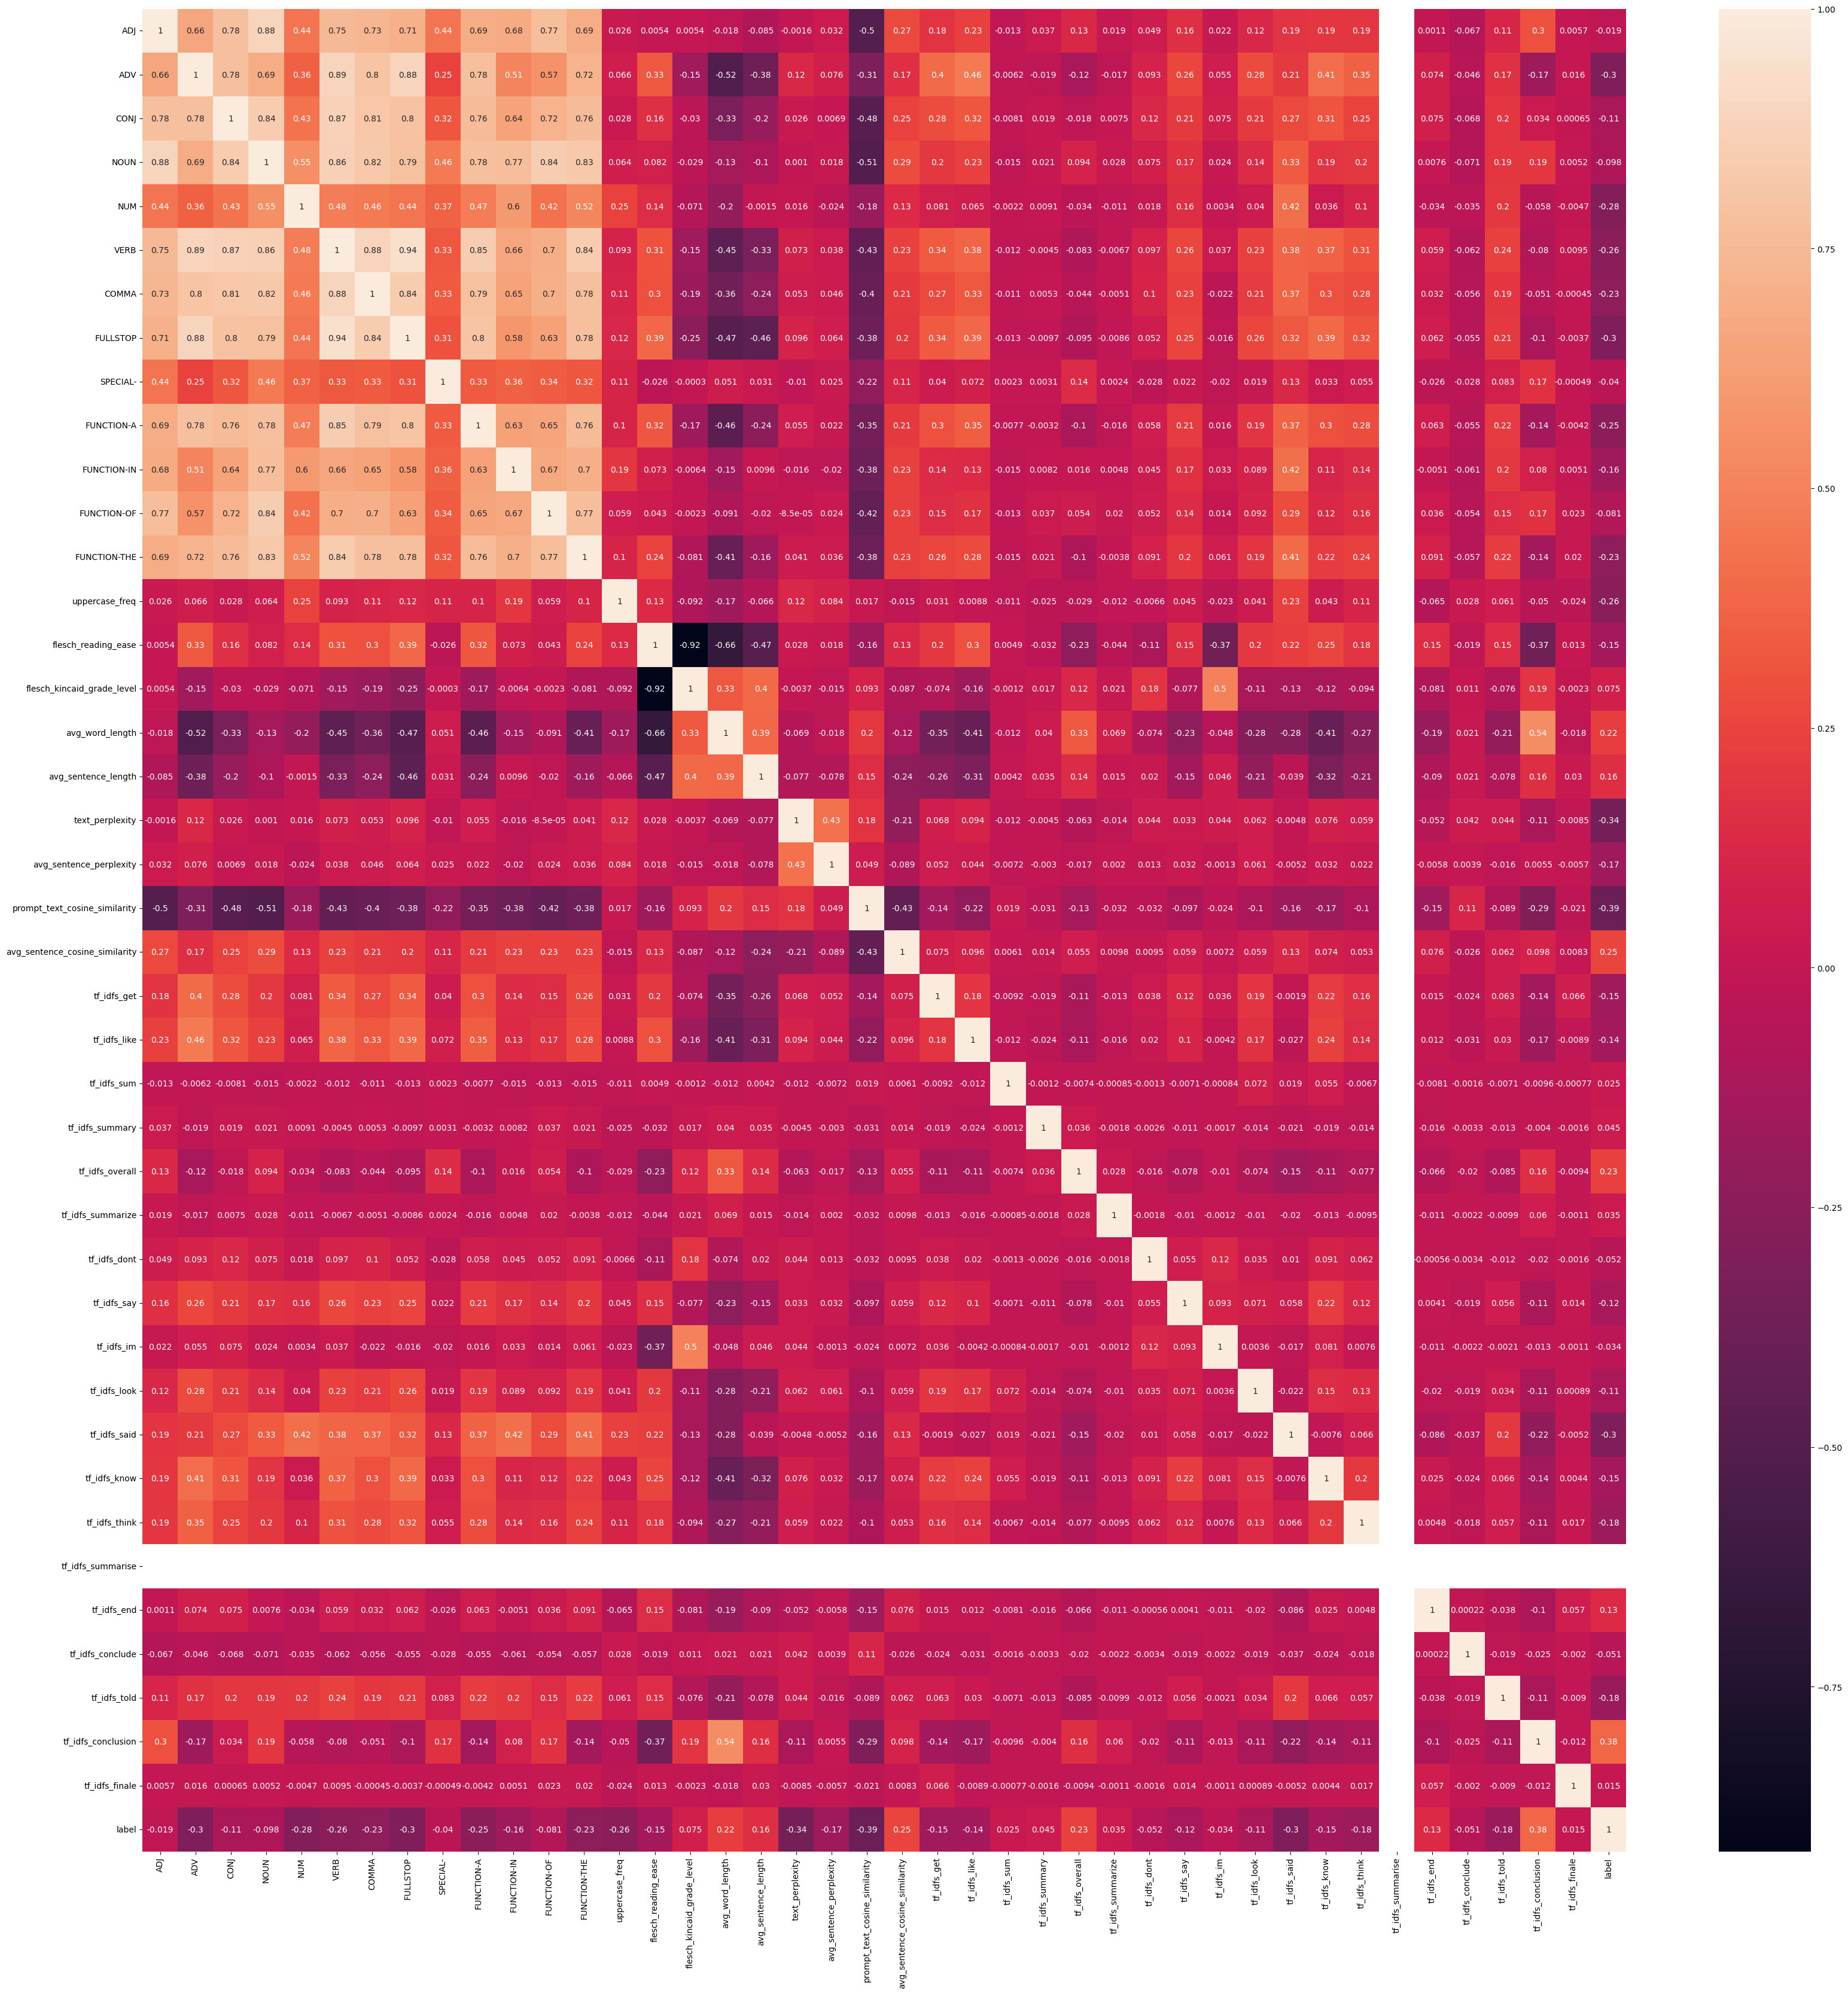

In [6]:
your_dataframe = pd.read_csv("data_matrix_gpt-3.5-turbo.csv")

correlation_matrix = your_dataframe.corr()
plt.figure(figsize=(40, 40))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [7]:
plt.figure(figsize=(10, 10))
correlation_with_target.plot(kind='bar')
plt.show()


NameError: name 'correlation_with_target' is not defined

<Figure size 1000x1000 with 0 Axes>